In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split

import xgboost as xgb

from sklearn.metrics import roc_auc_score, r2_score, mean_squared_error,classification_report

In [2]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import ElasticNet

In [3]:
train=pd.read_csv("../data/train/datacountstudents_train.csv")
train=train.drop(['id'], axis=1)
#train.head()

In [4]:
X_train=train.drop(['yC'], axis=1)
Y_train=train['yC']
X_train.shape, Y_train.shape

((120, 32), (120,))

In [5]:
test=pd.read_csv("../data/test/datacountstudents_test.csv")
test=test.drop(['id'], axis=1)
#test.head()

In [6]:
X_test=test.drop(['yC'], axis=1)
Y_test=test['yC']
X_test.shape, Y_test.shape

((30, 32), (30,))

#### Análisis variables numéricas vs target

Resumen estadístico

In [7]:
train.describe()

,yC,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32
count,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,...,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000
mean,1.216667,64.530643,49.414167,0.308333,0.150000,0.033333,0.125000,0.083333,15.478996,28.133333,...,0.228209,0.027143,6.450000,5.558333,78.822689,0.141667,0.041667,3.866667,0.300111,0.515788
std,1.258139,10.093439,40.977939,0.463741,0.358569,0.180258,0.332106,0.277544,1.913951,15.052253,...,0.335089,0.112337,0.877832,0.985575,49.591147,0.350170,0.200664,2.145675,0.195522,0.297028
min,0.000000,34.217000,4.600000,0.000000,0.000000,0.000000,0.000000,0.000000,10.617270,0.000000,...,0.000000,0.000000,5.000000,3.000000,11.087400,0.000000,0.000000,1.000000,0.020398,0.040737
25%,0.000000,57.452500,14.300000,0.000000,0.000000,0.000000,0.000000,0.000000,14.586870,27.750000,...,0.001525,0.000000,6.000000,5.000000,43.637425,0.000000,0.000000,2.000000,0.107324,0.213143
50%,1.000000,67.946500,37.900000,0.000000,0.000000,0.000000,0.000000,0.000000,15.421435,31.000000,...,0.019950,0.000100,6.000000,6.000000,66.143600,0.000000,0.000000,4.000000,0.262157,0.495616
75%,2.000000,71.690097,77.500000,1.000000,0.000000,0.000000,0.000000,0.000000,16.542645,40.250000,...,0.407775,0.001225,7.000000,6.000000,104.938750,0.000000,0.000000,6.000000,0.494643,0.808403
max,7.000000,78.836829,159.400000,1.000000,1.000000,1.000000,1.000000,1.000000,20.850060,45.000000,...,0.985000,0.746200,9.000000,7.000000,344.830000,1.000000,1.000000,7.000000,0.662330,0.996328


Correlación

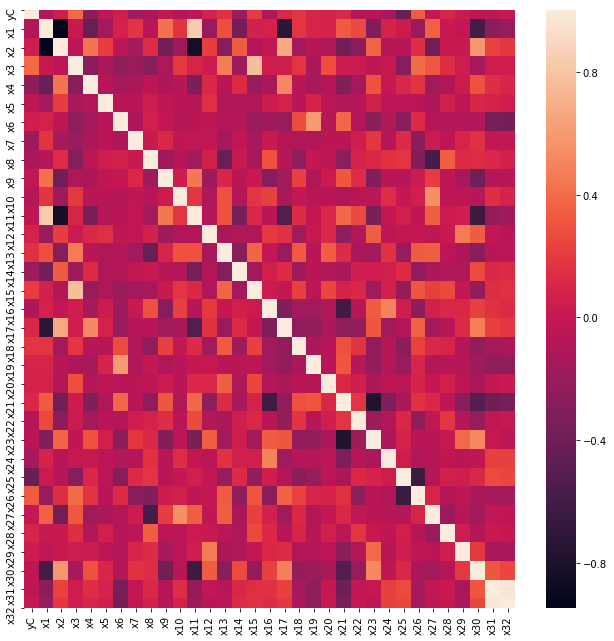

In [8]:
corrmat = train.corr()
fig, ax = plt.subplots()
fig.set_size_inches(11,11)
sns.heatmap(corrmat)

Estandarización de regresoras Train

In [9]:
num_features = ['x1','x2','x8','x9','x10','x11','x12','x21','x22','x23','x24','x25','x26','x27','x30','x31','x32']

In [10]:
num_pipeline = Pipeline([
    ('scaler',StandardScaler()),
    ('imputer',SimpleImputer(strategy='median'))
])

col_transformer = ColumnTransformer(transformers=[
    ('num', num_pipeline, num_features)
])

In [11]:
columns=X_train.columns.values.tolist()

In [12]:
col_transformer.fit(X_train.fillna(0))

ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('num',
                                 Pipeline(memory=None,
                                          steps=[('scaler',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True)),
                                                 ('imputer',
                                                  SimpleImputer(add_indicator=False,
                                                                copy=True,
                                                                fill_value=None,
                                                                missing_values=nan,
                                                                strategy='median',
                      

In [13]:
X_train[num_features]=col_transformer.transform(X_train.fillna(0))

Estandarización de regresoras Test

In [14]:
X_test[num_features]=col_transformer.transform(X_test.fillna(0))

Selección de variables

In [15]:
# Modelo con todas las características para determinar importancia

seed_val = 99
np.random.seed(seed_val)

model_all_features = LogisticRegression(C=1.0, l1_ratio=0.75, penalty='elasticnet', multi_class='multinomial', 
                                        solver='saga', max_iter=10000)

model_all_features.fit(X_train, Y_train)

y_pred_test = model_all_features.predict(X_test)
r2_score_all = r2_score(Y_test, y_pred_test)
print('Test all features model R2 = %f' % (r2_score_all))

Test all features model R2 = -0.183486


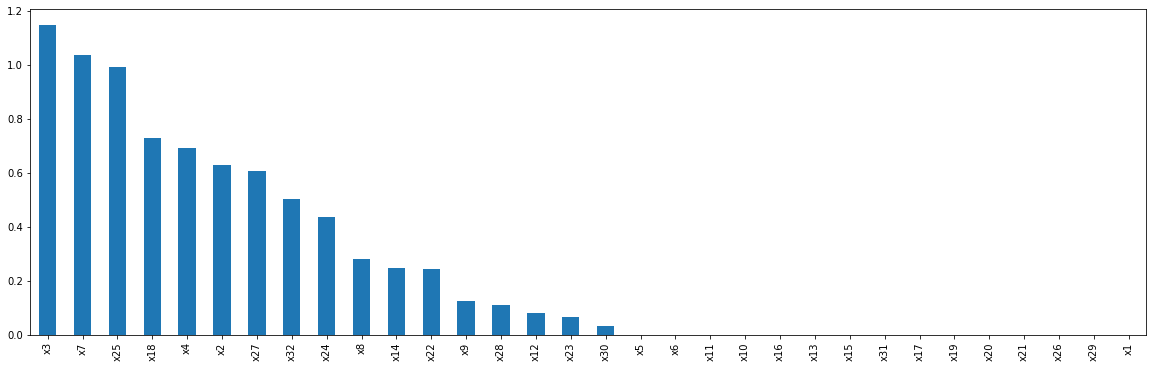

In [16]:
features = pd.Series(abs(model_all_features.coef_[0,:])) # esto con valor absoluto?
features.index = X_train.columns

features.sort_values(ascending=False, inplace=True)

features.plot.bar(figsize=(20,6))

In [17]:
features = list(features.index)
features

['x3',
 'x7',
 'x25',
 'x18',
 'x4',
 'x2',
 'x27',
 'x32',
 'x24',
 'x8',
 'x14',
 'x22',
 'x9',
 'x28',
 'x12',
 'x23',
 'x30',
 'x5',
 'x6',
 'x11',
 'x10',
 'x16',
 'x13',
 'x15',
 'x31',
 'x17',
 'x19',
 'x20',
 'x21',
 'x26',
 'x29',
 'x1']

In [18]:
# Modelo con la característca más importante (desde la que se inicia la adición)

seed_val = 99
np.random.seed(seed_val)

model_one_feature = LogisticRegression(C=1.0, l1_ratio=0.75, penalty='elasticnet', multi_class='multinomial', 
                                        solver='saga', max_iter=10000)

model_one_feature.fit(X_train[features[0]].to_frame(), Y_train)

y_pred_test = model_one_feature.predict(X_test[features[0]].to_frame())
r2_score_first = r2_score(Y_test, y_pred_test)
print('Test one feature model R2=%f' % (r2_score_first))

Test one feature model R2=-0.761468


In [19]:
# Adición de características y evaluación de modelos, una a la vez (en orden de importancia)

tol = 0.001

print('doing recursive feature addition')

features_to_keep = [features[0]]

count = 1

for feature in features[1:]:
    print()
    print('testing feature: ', feature, ' which is feature ', count,
          ' out of ', len(features))
    count = count + 1

    model_int = LogisticRegression(C=1.0, l1_ratio=0.75, penalty='elasticnet', multi_class='multinomial', 
                                        solver='saga', max_iter=10000)

    model_int.fit(
        X_train[features_to_keep + [feature] ], Y_train)

    y_pred_test = model_int.predict(
        X_test[features_to_keep + [feature] ])

    r2_score_int = r2_score(Y_test, y_pred_test)
    print('New Test R2={}'.format((r2_score_int)))

    print('All features Test R2={}'.format((r2_score_first)))

    diff_r2 = r2_score_int - r2_score_first

    if diff_r2 >= tol:
        print('Increase in r2 = {}'.format(diff_r2))
        print('keep: ', feature)
        print

        r2_score_first = r2_score_int

        features_to_keep.append(feature)
    else:
        print('Increase in r2 = {}'.format(diff_r2))
        print('remove: ', feature)
        print

print()
print('DONE!!')
print('total features to keep: ', len(features_to_keep))
print('selected features: ', features_to_keep)
print('final test R2 score={}'.format(r2_score_first))

doing recursive feature addition

testing feature:  x7  which is feature  1  out of  32
New Test R2=-0.7614678899082572
All features Test R2=-0.7614678899082572
Increase in r2 = 0.0
remove:  x7

testing feature:  x25  which is feature  2  out of  32
New Test R2=-0.05963302752293598
All features Test R2=-0.7614678899082572
Increase in r2 = 0.7018348623853212
keep:  x25

testing feature:  x18  which is feature  3  out of  32
New Test R2=-0.05963302752293598
All features Test R2=-0.05963302752293598
Increase in r2 = 0.0
remove:  x18

testing feature:  x4  which is feature  4  out of  32
New Test R2=-0.05963302752293598
All features Test R2=-0.05963302752293598
Increase in r2 = 0.0
remove:  x4

testing feature:  x2  which is feature  5  out of  32
New Test R2=0.1192660550458714
All features Test R2=-0.05963302752293598
Increase in r2 = 0.17889908256880738
keep:  x2

testing feature:  x27  which is feature  6  out of  32
New Test R2=0.10550458715596323
All features Test R2=0.119266055045871

In [20]:
# Modelo con características seleccionadas

seed_val = 99
np.random.seed(seed_val)

final_model = LogisticRegression(C=1.0, l1_ratio=0.75, penalty='elasticnet', multi_class='multinomial', 
                                        solver='saga', max_iter=10000)

final_model.fit(X_train[features_to_keep], Y_train)

y_pred_test = final_model.predict(X_test[features_to_keep])

r2_score_final = r2_score(Y_test, y_pred_test)
print('Test selected features R2=%f' % (r2_score_final))

mse = mean_squared_error(Y_test, y_pred_test)
print('Test selected features mse=%f' % (mse))

Test selected features R2=0.270642
Test selected features mse=1.766667


In [21]:
print(classification_report(Y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.54      0.78      0.64         9
           1       0.25      0.40      0.31         5
           2       0.50      0.30      0.37        10
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         0

    accuracy                           0.40        30
   macro avg       0.16      0.18      0.16        30
weighted avg       0.37      0.40      0.37        30



C:\Users\Juan Camilo Ceballos\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Juan Camilo Ceballos\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Juan Camilo Ceballos\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Juan Camilo Ceballos\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Rec

In [22]:
pd.crosstab(Y_test,y_pred_test,rownames=["Actual"],colnames=["Predictions"])

Predictions,0,1,2,3,7
Actual,,,,,
0,7,2,0,0,0
1,2,2,1,0,0
2,4,2,3,1,0
3,0,2,0,0,0
4,0,0,2,0,0
5,0,0,0,0,1
6,0,0,0,1,0


In [23]:
to_export = pd.concat([Y_test, pd.DataFrame(y_pred_test)],axis=1)

In [24]:
to_export.columns=['real','guess']

In [25]:
to_export

,real,guess
0,0,0
1,3,1
2,0,1
3,2,1
4,2,2
5,3,1
6,2,3
7,1,2
8,0,0
9,1,0


In [26]:
#to_export.to_csv('./validation/conteo/camilo.csv')

Conversión

In [27]:
y_pred_test=np.where(y_pred_test!=0, 1, y_pred_test)

In [28]:
Y_test=np.where(Y_test!=0, 1, Y_test)

In [29]:
print(classification_report(Y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.54      0.78      0.64         9
           1       0.88      0.71      0.79        21

    accuracy                           0.73        30
   macro avg       0.71      0.75      0.71        30
weighted avg       0.78      0.73      0.74        30



In [30]:
pd.crosstab(Y_test,y_pred_test,rownames=["Actual"],colnames=["Predictions"])

Predictions,0,1
Actual,,
0,7,2
1,6,15
